# PYTORCH_forecasting를 사용한 전력사용량 예측


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/inpu'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
pip install torch -f https://download.pytorch.org/whl/torch_stable.html.

Looking in links: https://download.pytorch.org/whl/torch_stable.html.
Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install pytorch-forecasting

     |████████████████████████████████| 112 kB 4.4 MB/s 


In [4]:
pip install torch -f https://download.pytorch.org/whl/torch_stable.html.

Looking in links: https://download.pytorch.org/whl/torch_stable.html.
Note: you may need to restart the kernel to use updated packages.


In [5]:
import numpy as np
import pandas as pd
import pandas_datareader.data as pdr
import matplotlib.pyplot as plt

import datetime

import torch
import torch.nn as nn
from torch.autograd import Variable 

import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

참고 : https://coding-yoon.tistory.com/131

In [6]:
import copy
import warnings
warnings.simplefilter('ignore')
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [7]:
train_df=pd.read_csv('../input/energy-dacon/train.csv',encoding = 'cp949')
test_df=pd.read_csv('../input/energy-dacon/test.csv',encoding = 'cp949')
submission_df=pd.read_csv('../input/energy-dacon/sample_submission.csv',encoding = 'cp949')

In [8]:
train_df.dtypes

num             int64
date_time      object
전력사용량(kWh)    float64
기온(°C)        float64
풍속(m/s)       float64
습도(%)         float64
강수량(mm)       float64
일조(hr)        float64
비전기냉방설비운영     float64
태양광보유         float64
dtype: object

In [9]:
train_df.isna().sum()

num           0
date_time     0
전력사용량(kWh)    0
기온(°C)        0
풍속(m/s)       0
습도(%)         0
강수량(mm)       0
일조(hr)        0
비전기냉방설비운영     0
태양광보유         0
dtype: int64

In [10]:
test_df.isna().sum()

num                0
date_time          0
기온(°C)          6720
풍속(m/s)         6720
습도(%)           6720
강수량(mm, 6시간)    8400
일조(hr, 3시간)     6720
비전기냉방설비운영       7784
태양광보유           8456
dtype: int64

In [11]:
temp_df=train_df[['num', '비전기냉방설비운영','태양광보유']]
ice={}
hot={}
count=0
for i in range(0, len(train_df), len(train_df)//60):
    count +=1
    ice[count]=train_df.loc[i,'비전기냉방설비운영']
    hot[count]=train_df.loc[i,'태양광보유']
    
    

In [12]:
test_EDA=copy.deepcopy(test_df)

In [13]:
for i in range(len(test_df)):
    test_EDA.loc[i, '비전기냉방설비운영']=ice[test_df['num'][i]]
    test_EDA.loc[i, '태양광보유']=hot[test_df['num'][i]]

In [14]:
test_EDA=test_EDA.interpolate(method='values')

In [15]:
def change_date(date_one_time):
    dateformat = "%Y-%m-%d %H"
    convert_one_time = datetime.datetime.strptime(date_one_time, dateformat)
    return convert_one_time

def insert_dateindex(df):
    date_time=df['date_time']
    convert_time=date_time.map(change_date)
    date_index=pd.DatetimeIndex(convert_time)
    df.index=date_index
    return df

def change_date_df(df):
    date_time=df['date_time']
    convert_time=date_time.map(change_date)
    df['date_time']=convert_time
    return df
    

In [16]:
# train_CI=insert_dateindex(train_df)
# test_CI=insert_dateindex(test_EDA)

In [17]:
test_EDA

,num,date_time,기온(°C),풍속(m/s),습도(%),"강수량(mm, 6시간)","일조(hr, 3시간)",비전기냉방설비운영,태양광보유
0,1,2020-08-25 00,27.800000,1.500000,74.000000,0.0,0.000000,0.0,0.0
1,1,2020-08-25 01,27.633333,1.366667,75.333333,0.0,0.000000,0.0,0.0
2,1,2020-08-25 02,27.466667,1.233333,76.666667,0.0,0.000000,0.0,0.0
3,1,2020-08-25 03,27.300000,1.100000,78.000000,0.0,0.000000,0.0,0.0
4,1,2020-08-25 04,26.900000,1.166667,79.666667,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...
10075,60,2020-08-31 19,28.633333,3.566667,66.000000,0.0,0.533333,1.0,1.0
10076,60,2020-08-31 20,28.266667,3.833333,67.000000,0.0,0.266667,1.0,1.0
10077,60,2020-08-31 21,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0
10078,60,2020-08-31 22,27.900000,4.100000,68.000000,0.0,0.000000,1.0,1.0


In [18]:
train_EDA=copy.deepcopy(train_df)
train_EDA=change_date_df(train_EDA)


In [19]:
train_EDA.dtypes

num                    int64
date_time     datetime64[ns]
전력사용량(kWh)           float64
기온(°C)               float64
풍속(m/s)              float64
습도(%)                float64
강수량(mm)              float64
일조(hr)               float64
비전기냉방설비운영            float64
태양광보유                float64
dtype: object

In [20]:
x_drop_list=['date_time','전력사용량(kWh)']
#x_drop_list=['전력사용량(kWh)']

In [21]:
#num1_train=train_df[train_df['num']==1]

In [22]:
#num1_train

In [23]:
train_EDA

,num,date_time,전력사용량(kWh),기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,1,2020-06-01 00:00:00,8179.056,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,2020-06-01 01:00:00,8135.640,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,1,2020-06-01 02:00:00,8107.128,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,1,2020-06-01 03:00:00,8048.808,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,1,2020-06-01 04:00:00,8043.624,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
122395,60,2020-08-24 19:00:00,4114.368,27.8,2.3,68.0,0.0,0.7,1.0,1.0
122396,60,2020-08-24 20:00:00,3975.696,27.3,1.2,71.0,0.0,0.0,1.0,1.0
122397,60,2020-08-24 21:00:00,3572.208,27.3,1.8,71.0,0.0,0.0,1.0,1.0
122398,60,2020-08-24 22:00:00,3299.184,27.1,1.8,74.0,0.0,0.0,1.0,1.0


In [24]:
#num== 1만 뽑아서 학습
x_drop_list=['date_time','전력사용량(kWh)','num']
num1_train=train_EDA[train_EDA['num']==1]
X=num1_train.drop(x_drop_list,axis=1)
y=num1_train[['전력사용량(kWh)']]

In [25]:
# ##########날짜 순 정렬#############
#sort_train=train_EDA.sort_values(by=['date_time'], axis=0)

In [26]:
#sort_train

In [27]:
X

,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2035,29.4,3.4,66.0,0.0,0.2,0.0,0.0
2036,28.7,1.9,69.0,0.0,0.0,0.0,0.0
2037,28.3,1.1,71.0,0.0,0.0,0.0,0.0
2038,28.3,2.4,72.0,0.0,0.0,0.0,0.0


In [28]:
X_newindex=X.reset_index()

In [29]:
X_newindex

,index,기온(°C),풍속(m/s),습도(%),강수량(mm),일조(hr),비전기냉방설비운영,태양광보유
0,0,17.6,2.5,92.0,0.8,0.0,0.0,0.0
1,1,17.7,2.9,91.0,0.3,0.0,0.0,0.0
2,2,17.5,3.2,91.0,0.0,0.0,0.0,0.0
3,3,17.1,3.2,91.0,0.0,0.0,0.0,0.0
4,4,17.0,3.3,92.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
2035,2035,29.4,3.4,66.0,0.0,0.2,0.0,0.0
2036,2036,28.7,1.9,69.0,0.0,0.0,0.0,0.0
2037,2037,28.3,1.1,71.0,0.0,0.0,0.0,0.0
2038,2038,28.3,2.4,72.0,0.0,0.0,0.0,0.0


In [30]:
drop_list=['num','date_time']
train_temp=num1_train.drop(drop_list,axis=1)
# drop_list=
# train_temp=train_EDA.drop()

In [31]:
train_newindex=train_temp.reset_index()

In [32]:
train_newtime=train_newindex.rename(columns={'index':'time'})

In [33]:
from pytorch_forecasting.data import (
     TimeSeriesDataSet,
     GroupNormalizer
 )

In [34]:
X_newindex['index'].max()

2039

In [35]:
group_ids=["기온(°C)"]

In [36]:
max_prediction_length = 6
training=TimeSeriesDataSet (data=train_newtime , 
                            time_idx ="time" , 
                            target="전력사용량(kWh)" , 
                            group_ids =group_ids,
                           allow_missing_timesteps = True,
                            max_prediction_length=max_prediction_length,
                           time_varying_known_reals=['time','비전기냉방설비운영','태양광보유'],
                           time_varying_unknown_reals=['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)'])


In [37]:
validation = TimeSeriesDataSet.from_dataset(training, train_newtime, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)


In [38]:
import pytorch_lightning as pl

In [39]:
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor

In [40]:
early_stop_callback = EarlyStopping(monitor="val_loss",
                                    min_delta=1e-4, patience=1,
                                    verbose=False, mode="min")
lr_logger = LearningRateMonitor()
trainer = pl.Trainer(
    max_epochs=100,
    gpus=0,
    gradient_clip_val=0.1,
    limit_train_batches=30,
    callbacks=[lr_logger, early_stop_callback],
)

In [41]:
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.metrics import QuantileLoss

In [42]:
tft = TemporalFusionTransformer.from_dataset(
    training,
    # not meaningful for finding the learning rate but otherwise very important
    learning_rate=0.03,
    hidden_size=32,  # most important hyperparameter apart from learning rate
    # number of attention heads. Set to up to 4 for large datasets
    attention_head_size=1,
    dropout=0.1,  # between 0.1 and 0.3 are good values
    hidden_continuous_size=16,  # set to <= hidden_size
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    # reduce learning rate if no improvement in validation loss after x epochs
    reduce_on_plateau_patience=4,
)

In [43]:
res = trainer.tuner.lr_find(
    tft, train_dataloader=train_dataloader, 
    val_dataloaders=val_dataloader, early_stop_threshold=1000.0, max_lr=3, min_lr=1e-6
)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

suggested learning rate: 0.013975186201644882


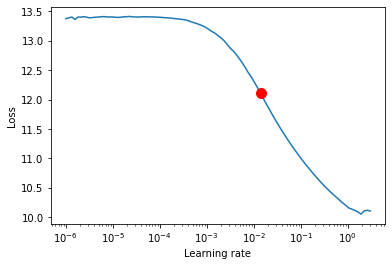

In [44]:
print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

In [45]:
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = tft.predict(val_dataloader)
(actuals - predictions).abs().mean()

tensor(15.6082)

In [46]:
raw_predictions, x = tft.predict(val_dataloader, mode="raw", return_x=True)

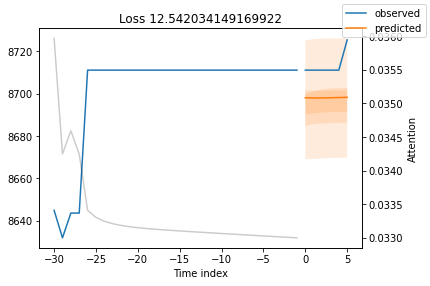

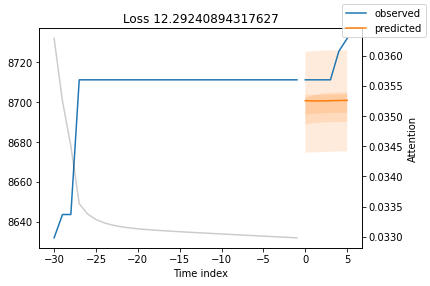

In [47]:
for idx in range(2):  # plot 10 examples
    tft.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)

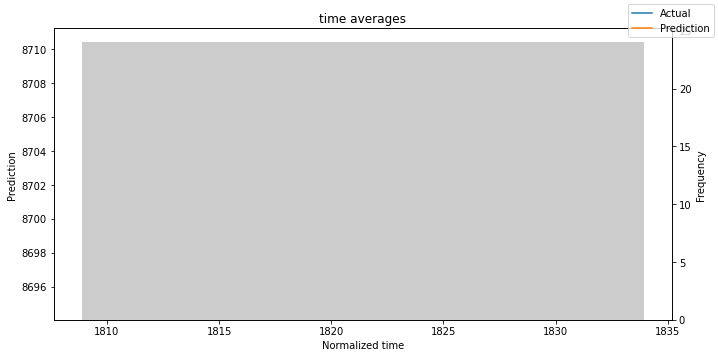

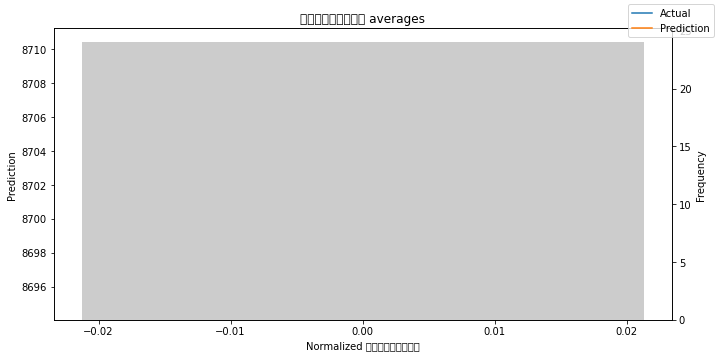

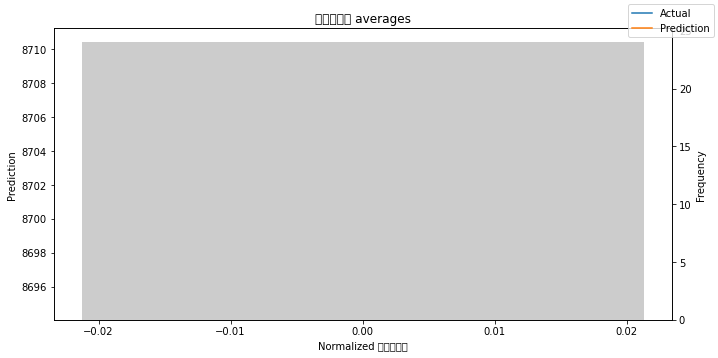

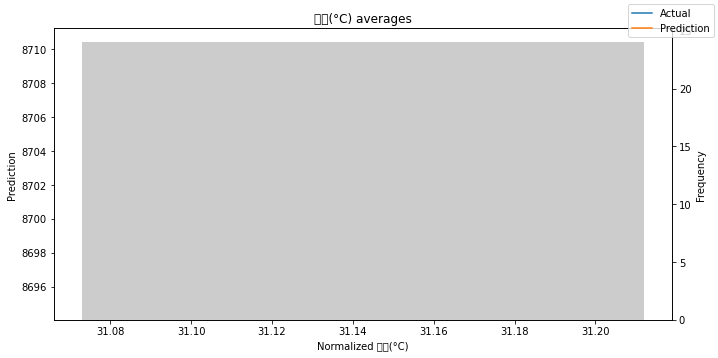

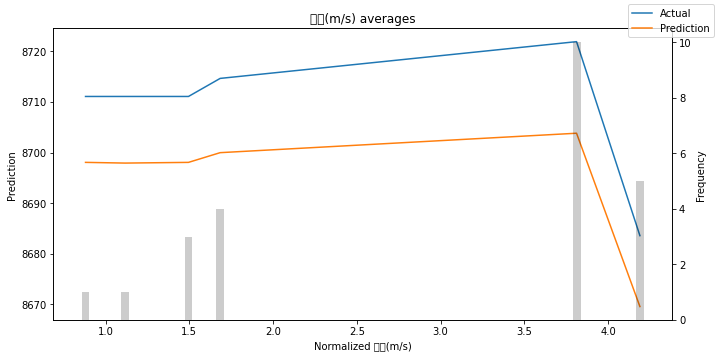

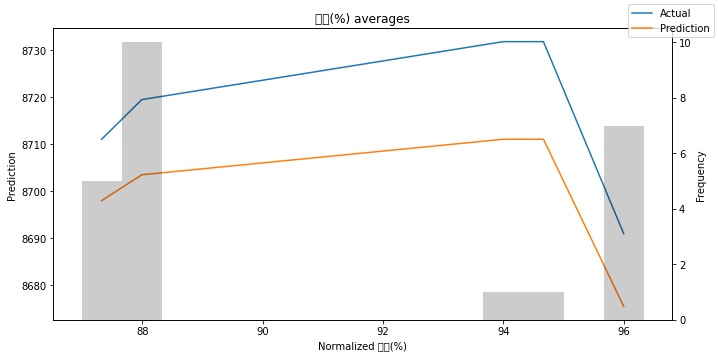

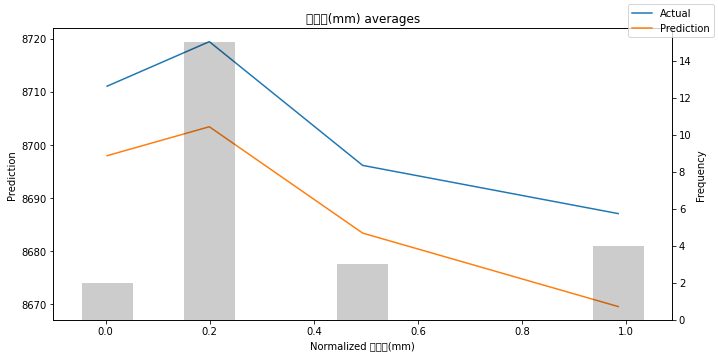

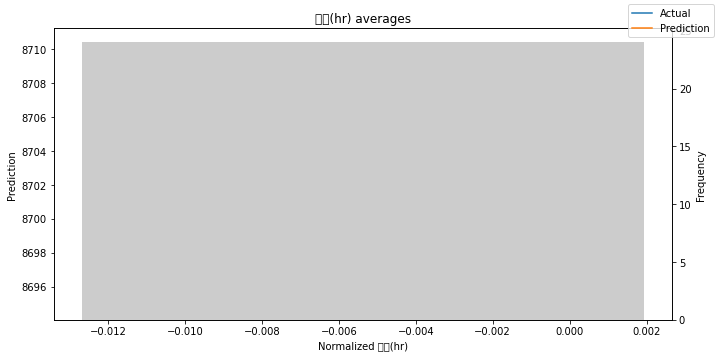

In [48]:
predictions, x = tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = tft.calculate_prediction_actual_by_variable(x, predictions)
tft.plot_prediction_actual_by_variable(predictions_vs_actuals);

In [49]:
# X=sort_train.drop(x_drop_list,axis=1)
# y=sort_train[['전력사용량(kWh)']]

In [50]:
#num== 1만 뽑아서 test

num1_test=test_EDA[test_EDA['num']==1]


In [51]:
train_newtime['time'].max()

2039

In [52]:

drop_list=['num','date_time']
test_temp=num1_test.drop(drop_list,axis=1)
test_newindex=test_temp.reset_index()
test_newtime=test_newindex.rename(columns={'index':'time'})


In [53]:
test_newtime['time']=test_newtime['time']+2040

In [54]:
test_newtime['time']

0      2040
1      2041
2      2042
3      2043
4      2044
       ... 
163    2203
164    2204
165    2205
166    2206
167    2207
Name: time, Length: 168, dtype: int64

In [55]:
submission_df

,num_date_time,answer
0,1 2020-08-25 00,0
1,1 2020-08-25 01,0
2,1 2020-08-25 02,0
3,1 2020-08-25 03,0
4,1 2020-08-25 04,0
...,...,...
10075,60 2020-08-31 19,0
10076,60 2020-08-31 20,0
10077,60 2020-08-31 21,0
10078,60 2020-08-31 22,0


In [56]:
raw_col=train_newtime.columns

In [57]:
raw_col

Index(['time', '전력사용량(kWh)', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)',
       '비전기냉방설비운영', '태양광보유'],
      dtype='object')

In [58]:
raw_col=train_newtime.drop('전력사용량(kWh)',axis=1).columns

In [59]:
raw_col

Index(['time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm)', '일조(hr)', '비전기냉방설비운영',
       '태양광보유'],
      dtype='object')

In [60]:
test_newtime.columns

Index(['time', '기온(°C)', '풍속(m/s)', '습도(%)', '강수량(mm, 6시간)', '일조(hr, 3시간)',
       '비전기냉방설비운영', '태양광보유'],
      dtype='object')

In [61]:
test_newtime.columns=raw_col

In [62]:
test_newtime['전력사용량(kWh)']=0

In [63]:
# testing=TimeSeriesDataSet (data=test_newtime , 
#                             time_idx ="time" , 
#                             target="전력사용량(kWh)" , 
#                             group_ids =group_ids,
#                            allow_missing_timesteps = True,
#                             max_prediction_length=max_prediction_length,
#                            time_varying_known_reals=['time','비전기냉방설비운영','태양광보유'],
#                            time_varying_unknown_reals=['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)'])

In [64]:
# val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

In [65]:
new_raw_predictions, new_x = tft.predict(test_newtime, mode="raw", return_x=True)


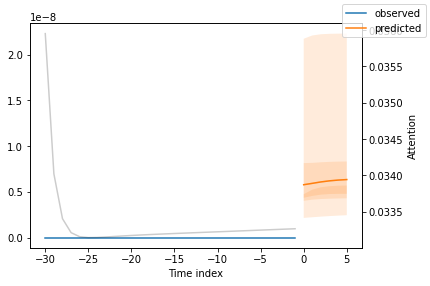

In [66]:
tft.plot_prediction(new_x, new_raw_predictions, idx=0, show_future_observed=False);

In [67]:
#submission_df

In [68]:
# submission_1=copy.deepcopy(submission_df)

In [69]:
# submission_1['answer']=data_predict_inverse

In [70]:
# submission_1.to_csv('lstm_submission1.csv', index=False)

In [71]:
# train_preds = np.zeros((len(train_X)))
# test_preds = np.zeros((len(test_X)))

# x_test_cuda = torch.tensor(test_X, dtype=torch.long).cuda()
# test = torch.utils.data.TensorDataset(x_test_cuda)
# test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)
